In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print(f'file {fn} was uploaded')
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
file kaggle.json was uploaded


In [ ]:
!kaggle datasets download -d masoumehsiar/Siardataset

Dataset URL: https://www.kaggle.com/datasets/masoumehsiar/Siardataset
License(s): unknown
Siardataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile
file_path ='/content/Siardataset.zip'
with ZipFile(file_path,'r') as zip_file:
  zip_file.extractall()
  print('Extraction Complete')

Extraction Complete


In [ ]:
!pip install imutils

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D , Input , ZeroPadding2D , BatchNormalization, Activation,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

In [ ]:
def crop_brain_contour(img,plot=False):
  if img is None:
    raise ValueError('Input image cannot be none')
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray,(5,5),0)
  thresh = cv2.threshold(gray,45,255,cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh,None,iterations=2)
  thresh = cv2.dilate(thresh,None , iterations=2)
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)

  if not cnts:
      raise ValueError("No contours found. The image might be too blank or noisy.")

  c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Crop the new image out of the original image using the four extreme points (left, right, top, bottom)
  new_image = img[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

  if plot:
      plt.figure()
      plt.subplot(1, 2, 1)
      plt.imshow(img)
      plt.title('Original Image')

      plt.subplot(1, 2, 2)
      plt.imshow(new_image)
      plt.title('Cropped Image')

      plt.show()

  return new_image


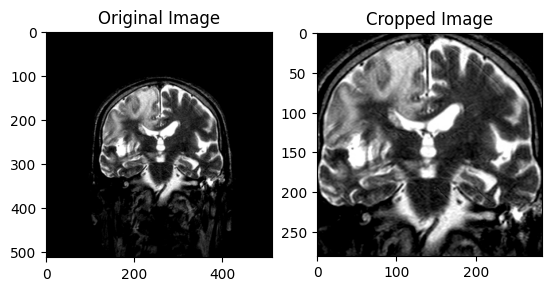

In [ ]:
img=cv2.imread('/content/Siar-dataset/Tumor/Tumor (10).jpg')
new_img = crop_brain_contour(img,True)

In [ ]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them.
    Arguments:
        dir_list: List of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # Load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            # Load the image
            image = cv2.imread(directory + '/' + filename)

            # Check if the image is loaded properly
            if image is None:
                print(f"Warning: Unable to load image: {directory + '/' + filename}")
                continue

            # Crop the brain and ignore the unnecessary rest part of the image
            try:
                image = crop_brain_contour(image, plot=False)
            except ValueError as e:
                print(f"Error processing image {filename}: {e}")
                continue

            # Resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # Normalize values
            image = image / 255.
            # Convert image to numpy array and append it to X
            X.append(image)
            # Append a value of 1 to the target array if the image is in the folder named 'yes', otherwise append 0.
            if 'Tumor' in directory:
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [ ]:
original_path = '/content/Siar-dataset/'

Original_yes = original_path + 'Tumor'
Original_no = original_path + 'Normal'

IMG_WIDTH, IMG_HEIGHT = (64, 64)

X, y = load_data([Original_yes, Original_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 6999
X shape is: (6999, 64, 64, 3)
y shape is: (6999, 1)


In [ ]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

In [ ]:
def split_data(X , y , test_size ):
  x_train , x_test_val , y_train , y_test_val = train_test_split(X,y,test_size=test_size)
  x_test , x_val , y_test , y_val = train_test_split(x_test_val,y_test_val,test_size=0.5)
  return x_train , y_train ,x_val , y_val , x_test ,y_test

In [ ]:
x_train , y_train ,x_val , y_val , x_test ,y_test = split_data(X,y,test_size=0.3)

In [ ]:
x_train.shape , y_train.shape ,x_val.shape , y_val.shape , x_test.shape ,y_test.shape

((4899, 64, 64, 3),
 (4899, 1),
 (1050, 64, 64, 3),
 (1050, 1),
 (1050, 64, 64, 3),
 (1050, 1))

In [ ]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

In [ ]:
def build_model(input_shape):
  x_input = Input(input_shape)
  x= ZeroPadding2D((2,2))(x_input)
  x=Conv2D(32 , (7,7) ,strides=(1,1))(x)
  x = BatchNormalization(axis=3)(x)
  x=Activation('relu')(x)
  x=MaxPooling2D((4,4))(x)

  x=Conv2D(64 , (5,5) ,strides=(1,1))(x)
  x = BatchNormalization(axis=3)(x)
  x=Activation('relu')(x)
  X=Dropout(0,25)(x)
  x=MaxPooling2D((2,2))(x)


  x=Conv2D(128 , (3,3) ,strides=(1,1))(x)
  x = BatchNormalization(axis=3)(x)
  x=Activation('relu')(x)
  X=Dropout(0,25)(x)

  x=Conv2D(256 , (3,3) ,strides=(1,1))(x)
  x = BatchNormalization(axis=3)(x)
  x=Activation('relu')(x)
  X=Dropout(0,25)(x)

  x=Flatten()(x)

  x=Dense(1,activation='sigmoid')(x)
  model=Model(inputs=x_input,outputs=x)
  return model

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
model = build_model(IMG_SHAPE)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 68, 68, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 11, 11, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 1, 1, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1, 1, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 427,201 (1.63 MB)

 Trainable params: 426,241 (1.63 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_val,y_val))

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9203 - loss: 0.1939 - val_accuracy: 0.8810 - val_loss: 0.3197
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9636 - loss: 0.1051 - val_accuracy: 0.8667 - val_loss: 0.3714
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9819 - loss: 0.0544 - val_accuracy: 0.8619 - val_loss: 0.3176
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9781 - loss: 0.0690 - val_accuracy: 0.9686 - val_loss: 0.0822
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9766 - loss: 0.0727 - val_accuracy: 0.9800 - val_loss: 0.0499
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9910 - loss: 0.0252 - val_accuracy: 0.9848 - val_loss: 0.0465
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9956 - loss: 0.0159 - val_accuracy: 0.9857 - val_loss: 0.0363
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9905 - loss: 0.0273 - val_accuracy: 

In [ ]:
history = model.history.history

In [ ]:
for key in history.keys():
  print(key)

accuracy
loss
val_accuracy
val_loss


In [ ]:
def plot_metrics(history):
  train_loss = history['loss']
  val_loss = history['val_loss']
  train_acc = history['accuracy']
  val_acc = history['val_accuracy']
  plt.figure(figsize=(8,8))
  plt.plot(train_loss,label='train loss')
  plt.plot(val_loss,label='val loss')
  plt.title('Loss')
  plt.legend()
  plt.show()

  plt.figure(figsize=(8,8))
  plt.plot(train_acc,label='train accuracy')
  plt.plot(val_acc,label='val accuracy')
  plt.title('Accuracy')
  plt.legend()
  plt.show()

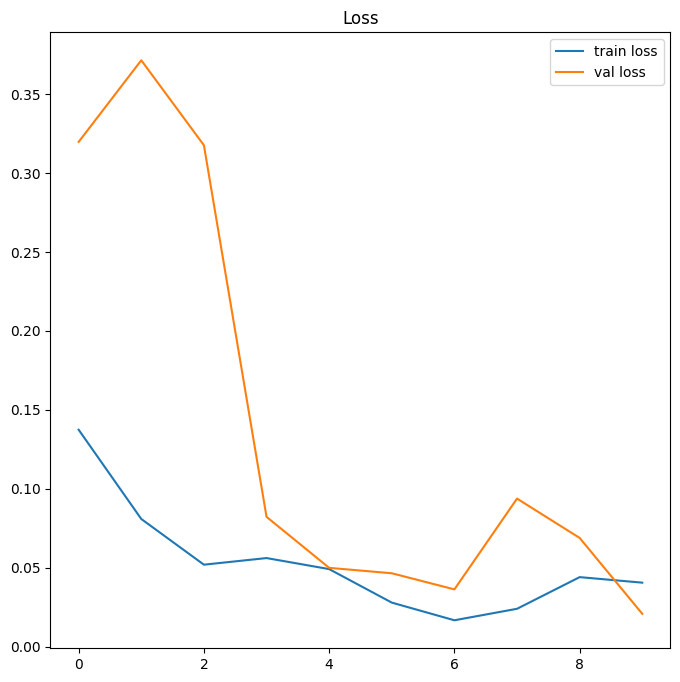

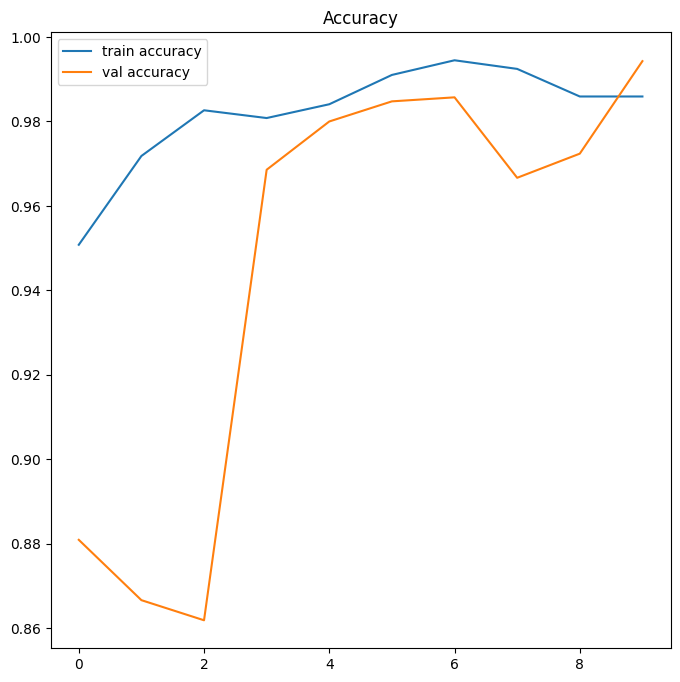

In [ ]:
plot_metrics(history)


In [ ]:
loss , access = model.evaluate(x_test,y_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9918 - loss: 0.0284


In [ ]:
y_test_prob =model.predict(x_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


In [ ]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9929221435793731
